# Optik Koherens Tomografiden hastalık teşhisi (Sınıflandırma)

<img src="oct.jpg" width="750" align="left">

        21. yüzyılda, optik koherens tomografinin (OCT) gelişimi, maküler hastalıkları teşhis etme ve tedavilerin gerekliliğini ve etkinliğini değerlendirme becerisinde çığır açmıştır. Dünya çapında her yıl gerçekleştirilen yaklaşık 30 milyon OCT taramasıyla en sık uygulanan tıbbi görüntüleme prosedürlerinden biri haline geldi. OCT görüntüleme artık dünya çapında önlenebilir körlüğün önde gelen nedenlerinden yaşa bağlı makula dejenerasyonu (AMD) ve diyabetik maküla ödeminin tanı ve tedavisine rehberlik eden bir standart haline gelmiştir.

-------------------------------------------------------------------------------------------------------------------------------------

# Veri seti

   OCT verilerini [buradan](https://data.mendeley.com/datasets/rscbjbr9sj/2) indirebilirsiniz.

-------------------------------------------------------------------------------------------------------------------------------------

## Standart kütüphaneleri içe aktarma

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

seed = 2019
np.random.seed(seed)
%matplotlib inline

## Dosyanın bulunduğu konum

In [2]:
path  = 'C:\\Users\\yasar\\Desktop\\OCT2017\\'
train = path + 'train\\'
test  = path + 'test\\'
path,train,test

('C:\\Users\\yasar\\Desktop\\OCT2017\\',
 'C:\\Users\\yasar\\Desktop\\OCT2017\\train\\',
 'C:\\Users\\yasar\\Desktop\\OCT2017\\test\\')

## Veri büyütme  (Data augmentation) 

[ImageDataGenerator()](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) 

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(zoom_range = 0.3,
                                   horizontal_flip = True
                                   )
test_datagen = ImageDataGenerator()


## Görüntüleri aktarma

[flow_from_directory()](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) 

In [4]:
train_gen = train_datagen.flow_from_directory(
                            directory = train, 
                            target_size = (160, 160), 
                            batch_size = 16, 
                            class_mode = 'categorical', 
                            shuffle=True)

test_gen = train_datagen.flow_from_directory(
                            directory = test, 
                            target_size = (160, 160), 
                            batch_size = 16, 
                            class_mode = 'categorical', 
                            shuffle=True)

Found 83484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


### Callbacks 
1. Öğrenme katsayısı azaltma [ReduceLROnPlateau()](https://keras.io/api/callbacks/reduce_lr_on_plateau/) 
2. Kontrol noktası - Her epochta ağırlıkları kaydetme [ModelCheckpoint()](https://keras.io/api/callbacks/model_checkpoint/)


In [5]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=2, mode='max')
cp = ModelCheckpoint(filepath='eff_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

## Model Oluşturma - Transfer Learning ( EfficientNet B5 )

    Araştırma yapılırken(2018) transfer learning modeli olarak InceptionV3 kullanılmış ve %96.6 accuracy skoru elde edilmiş. Fakat günümüzde(2020) InceptionV3'den daha başarılı modeller mevcut. Bu nedenle kursta EfficientNet modelini kullanıyoruz. Bu model accuracy skoru %99.3'ye kadar çıkartabiliyor 

In [6]:
from efficientnet.keras import EfficientNetB5
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


model = Sequential()
model.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(160,160,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4,activation = 'softmax'))
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [170]:
history_eff = model.fit(
           train_gen, steps_per_epoch=train_gen.samples/16, 
           epochs=10,        
           validation_data=test_gen, 
           validation_steps=test_gen.samples // 16,
           callbacks=[lr, cp],
           verbose=1)

Epoch 1/5
5218/5217 [==============================] - 1604s 307ms/step - loss: 0.1999 - accuracy: 0.9353 - val_loss: 0.0413 - val_accuracy: 0.9899 - lr: 0.0010
Epoch 2/5
5218/5217 [==============================] - 1568s 301ms/step - loss: 0.1702 - accuracy: 0.9442 - val_loss: 0.0593 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 3/5
5218/5217 [==============================] - 1579s 303ms/step - loss: 0.1567 - accuracy: 0.9485 - val_loss: 0.0288 - val_accuracy: 0.9909 - lr: 0.0010
Epoch 4/5
5218/5217 [==============================] - 1742s 334ms/step - loss: 0.1471 - accuracy: 0.9517 - val_loss: 0.0402 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 5/5
5218/5217 [==============================] - 1522s 292ms/step - loss: 0.1367 - accuracy: 0.9549 - val_loss: 0.0355 - val_accuracy: 0.9919 - lr: 0.0010


## Basit CNN ile deneme

In [55]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization

model_2 = Sequential([

Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
MaxPool2D((2, 2)),
    
Conv2D(32, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),
    
Conv2D(256, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

Flatten(),
Dense(units=1024, activation='relu'),
Dropout(rate=0.3),

Dense(units=4, activation='softmax') ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [59]:
cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

history_cnn = model_2.fit(
           train_gen, 
           steps_per_epoch=train_gen.samples/32, 
           epochs=10,        
           validation_data=test_gen, 
           validation_steps=test_gen.samples // 32,
           callbacks = [cp])

Epoch 1/20
2609/2608 [==============================] - 922s 353ms/step - loss: 0.3280 - accuracy: 0.8903 - val_loss: 0.1719 - val_accuracy: 0.9375
Epoch 2/20
2609/2608 [==============================] - 887s 340ms/step - loss: 0.2861 - accuracy: 0.9059 - val_loss: 0.4937 - val_accuracy: 0.8216
Epoch 3/20
2609/2608 [==============================] - 872s 334ms/step - loss: 0.2588 - accuracy: 0.9152 - val_loss: 0.0465 - val_accuracy: 0.9879
Epoch 4/20
2609/2608 [==============================] - 893s 342ms/step - loss: 0.2421 - accuracy: 0.9209 - val_loss: 0.1521 - val_accuracy: 0.9415
Epoch 5/20
2609/2608 [==============================] - 881s 338ms/step - loss: 0.2275 - accuracy: 0.9260 - val_loss: 0.0599 - val_accuracy: 0.9859
Epoch 6/20
2609/2608 [==============================] - 830s 318ms/step - loss: 0.2168 - accuracy: 0.9293 - val_loss: 0.1112 - val_accuracy: 0.9647
Epoch 7/20
2609/2608 [==============================] - 827s 317ms/step - loss: 0.2063 - accuracy: 0.9319 - val_

# Accuracy-Loss grafiği

#### Accuracy

In [172]:
history = history_eff

Text(0.5, 0, 'epoch')

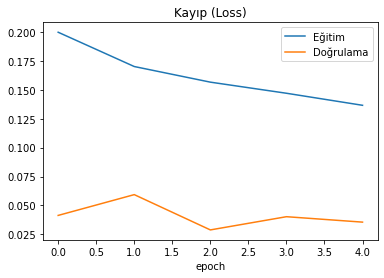

In [178]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp (Loss)')
plt.xlabel('epoch')

#### Loss

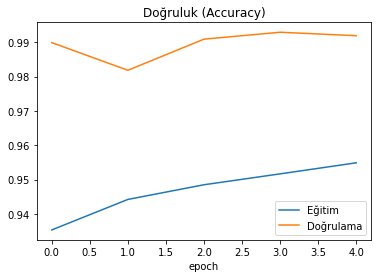

In [179]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk (Accuracy)')
plt.xlabel('epoch')
plt.show()

# Hata Matrisi (Confusion Matrix)

#### Verileri aktarma 

In [180]:
dosya = os.listdir(path+'train\\')

In [181]:
test_data = []
test_labels = []

for name in dosya:
    for img in os.listdir(test + name + '\\'):
        img = plt.imread(test + name + '\\' + img)
        img = cv2.resize(img, (160, 160))
        img = np.dstack([img, img, img])
        img = img.astype('float32')
        
        if   name =='CNV':
            label = 0
        elif name =='DME':
            label = 1
        elif name =='DRUSEN':
            label = 2
        elif name =='NORMAL':
            label = 3
            
        test_data.append(img)
        test_labels.append(label)
        
x_test = np.array(test_data)
y_test = np.array(test_labels)
y_pred_clas = model.predict_classes(x_test)# np.argmax(model.predict(x), axis=-1)
y_pred= model.predict(x_test)


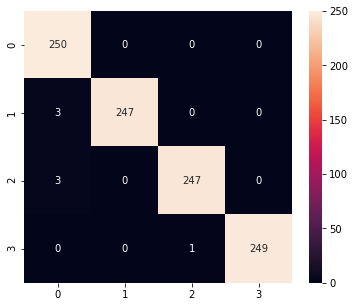

In [182]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_clas)
plt.figure(figsize = (6,5))
sns.heatmap(cm,fmt='.4g', annot=True)

# ROC Eğiris ()

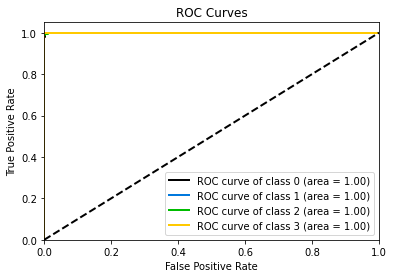

In [183]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_test,
                       y_pred,
                       plot_micro=False,
                       plot_macro=False)
plt.show()

# Occlusion Sensitivity

Tıkanma hassasiyeti, derin öğrenme modeliyle belirli bir sınıflandırma yapılırken bir görüntünün hangi bölümlerinin en önemli olduğunu anlamak için kullanılan basit bir tekniktir.

<img src="asd.gif" width="350" align="left">

görüntünün bir kısmı kapatılarak, modelin yaptığı tahmini etkileyip etkilemediğine bakılır.

In [166]:
occluding_size = 70
occluding_stride =  10

image = cv2.imread('D1.jpeg')
im = cv2.resize(image, (160, 160))
im2 = im.astype(np.float32)
im3 = np.expand_dims(im2, axis=0)
out = model.predict(im3)
out = out[0]
m = max(out)
index_object = [i for i, j in enumerate(out) if j == m]
height, width, _ = image.shape
output_height = int((height-occluding_size) / occluding_stride + 1)
output_width = int((width-occluding_size) / occluding_stride + 1)
heatmap = np.zeros((output_height, output_width))
heatmap.shape

(43, 45)

In [167]:
import copy
from tqdm.notebook import tqdm

a = []

for h in tqdm(range(output_height)):
        #print('scanning position (%s)'%(h))
        for w in range(output_width):
            h_start = h * occluding_stride
            w_start = w * occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            input_image = copy.copy(image)
            input_image[h_start:h_end, w_start:w_end,:] = 0
            a.append(input_image)
            im = cv2.resize(input_image, (160, 160))
            im = im.astype(np.float32)
            im = np.expand_dims(im, axis=0)
            out = model.predict(im)
            out = out[0]
            prob = (out[index_object]) 
            heatmap[h,w] = prob

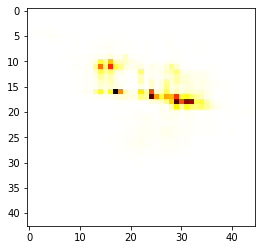

In [168]:
plt.imshow(heatmap,cmap='hot')

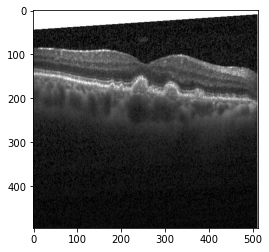

In [169]:
import copy
input_image2 = copy.copy(image)
plt.imshow(input_image2)